# Verbatim Coding Analysis: From Customer Voice to Actionable Strategy

## Project Overview

In the competitive world of women's e-commerce, customer feedback is a goldmine. However, with thousands of reviews pouring in, manually sifting through this unstructured text to find actionable insights is a near-impossible task. How can a business quickly identify if a new dress line has a sizing issue, or if a drop in ratings is due to fabric quality or slow shipping?

This notebook tackles this challenge head-on by building an automated **Verbatim Coding System**. It acts as an AI-powered analyst that reads, understands, and categorizes every single review, transforming a sea of raw feedback into a clear, prioritized roadmap for business improvement. We will move beyond simple star ratings to answer the crucial question: ***"Why?"***

The system's intelligence is built on a sophisticated, multi-layered approach:

### Key Capabilities:
- **Hybrid AI Approach**: Combines the precision of keyword-based rules with the discovery power of unsupervised machine learning (clustering) to ensure both accuracy and the ability to find new, emerging themes.
- **Sentiment-Driven Insights**: Goes beyond *what* customers say to understand *how they feel*, adding crucial emotional context (positive, negative, neutral) to each identified topic.
- **Actionable Priority Matrix**: Moves beyond simple charts to generate a business-focused matrix that weighs the **frequency** of a problem against its **impact** on customer ratings, telling you exactly what to fix first for maximum ROI.
- **Reliable & Production-Ready**: Implements a quality assurance layer with confidence scoring and exports trained models, making the entire system deployable for ongoing, real-time feedback analysis.

![Ecommerce Pic](https://unctad.org/sites/default/files/inline-images/2019-10-23_eTrade4Women_400x267.jpg)

### Dataset:
This analysis is performed on the **Women's E-commerce Clothing Reviews** dataset from [Kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews), containing over 23,000 real-world customer reviews.

## 🛠️ 1. Environment Setup and Data Loading
Before diving into analysis, we need to establish our technical foundation. This includes importing all necessary libraries for NLP, machine learning, visualization, and data manipulation. We'll also set up a proper directory structure for organizing our outputs and ensure all required NLTK resources are downloaded.

In [ ]:
# Core librraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP and ML libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Utility libraries
import re
import json
import pickle
from collections import Counter, defaultdict
from datetime import datetime
import os

# Visualization libraries
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Additional import for natural language processing
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
from matplotlib.patches import Rectangle

print("🚀 Environment setup complete!")

🚀 Environment setup complete!


### Directory Structure Setup
Organizing our outputs from the beginning ensures reproducibility and makes it easier to share results with stakeholders. We'll create separate folders for visualizations, reports, models, and processed data.

In [3]:
# Create directory structure for outputs
directories = [
    'outputs',
    'outputs/visualizations', 
    'outputs/reports',
    'outputs/models',
    'outputs/data'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

print("📁 Directory structure created!")

📁 Directory structure created!


In [4]:
# Load Data
df = pd.read_csv("../data/Womens Clothing E-Commerce Reviews.csv" , index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
# Display basic info
print(f"\n📋 Dataset Overview:")
print(f"   • Age range: {df['Age'].min()} - {df['Age'].max()}")
print(f"   • Rating range: {df['Rating'].min()} - {df['Rating'].max()}")
print(f"   • Total clothing items: {df['Clothing ID'].nunique():,}")
print(f"   • Product categories: {df['Department Name'].nunique()}")

# Display column information
print(f"\n📊 Column Information:")
for col in df.columns:
    dtype = df[col].dtype
    non_null = df[col].count()
    null_pct = (len(df) - non_null) / len(df) * 100
    print(f"   • {col}: {dtype} ({non_null:,} non-null, {null_pct:.1f}% missing)")


📋 Dataset Overview:
   • Age range: 18 - 99
   • Rating range: 1 - 5
   • Total clothing items: 1,206
   • Product categories: 6

📊 Column Information:
   • Clothing ID: int64 (23,486 non-null, 0.0% missing)
   • Age: int64 (23,486 non-null, 0.0% missing)
   • Title: object (19,676 non-null, 16.2% missing)
   • Review Text: object (22,641 non-null, 3.6% missing)
   • Rating: int64 (23,486 non-null, 0.0% missing)
   • Recommended IND: int64 (23,486 non-null, 0.0% missing)
   • Positive Feedback Count: int64 (23,486 non-null, 0.0% missing)
   • Division Name: object (23,472 non-null, 0.1% missing)
   • Department Name: object (23,472 non-null, 0.1% missing)
   • Class Name: object (23,472 non-null, 0.1% missing)


## 🔍 2. Exploratory Data Analysis (EDA)
Before building our verbatim coding system, we need to understand the data patterns, distributions, and relationships. This EDA will inform our coding categories and help identify potential issues or opportunities. We'll examine rating distributions, customer demographics, review characteristics, and departmental differences.

In [6]:
# Dataset structure analysis
print("🔍 DATASET STRUCTURE ANALYSIS")
print("=" * 50)

# Basic statistics
print("📊 Basic Statistics:")
print(f"Total Reviews: {len(df):,}")
print(f"Missing Values per Column:")
for col in df.columns:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    print(f"   {col}: {missing_count:,} ({missing_pct:.1f}%)")

print(f"\n📈 Rating Distribution:")
rating_dist = df['Rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    print(f"   {rating} stars: {count:,} reviews ({count/len(df)*100:.1f}%)")

print(f"\n👗 Department Distribution:")
dept_dist = df['Department Name'].value_counts()
for dept, count in dept_dist.head().items():
    print(f"   {dept}: {count:,} reviews ({count/len(df)*100:.1f}%)")

# Additional insights
print(f"\n💡 Key Insights:")
print(f"   • Average rating: {df['Rating'].mean():.2f}")
print(f"   • Recommendation rate: {df['Recommended IND'].mean()*100:.1f}%")
print(f"   • Reviews with text: {df['Review Text'].notna().sum():,} ({df['Review Text'].notna().mean()*100:.1f}%)")
print(f"   • Reviews with titles: {df['Title'].notna().sum():,} ({df['Title'].notna().mean()*100:.1f}%)")

🔍 DATASET STRUCTURE ANALYSIS
📊 Basic Statistics:
Total Reviews: 23,486
Missing Values per Column:
   Clothing ID: 0 (0.0%)
   Age: 0 (0.0%)
   Title: 3,810 (16.2%)
   Review Text: 845 (3.6%)
   Rating: 0 (0.0%)
   Recommended IND: 0 (0.0%)
   Positive Feedback Count: 0 (0.0%)
   Division Name: 14 (0.1%)
   Department Name: 14 (0.1%)
   Class Name: 14 (0.1%)

📈 Rating Distribution:
   1 stars: 842 reviews (3.6%)
   2 stars: 1,565 reviews (6.7%)
   3 stars: 2,871 reviews (12.2%)
   4 stars: 5,077 reviews (21.6%)
   5 stars: 13,131 reviews (55.9%)

👗 Department Distribution:
   Tops: 10,468 reviews (44.6%)
   Dresses: 6,319 reviews (26.9%)
   Bottoms: 3,799 reviews (16.2%)
   Intimate: 1,735 reviews (7.4%)
   Jackets: 1,032 reviews (4.4%)

💡 Key Insights:
   • Average rating: 4.20
   • Recommendation rate: 82.2%
   • Reviews with text: 22,641 (96.4%)
   • Reviews with titles: 19,676 (83.8%)


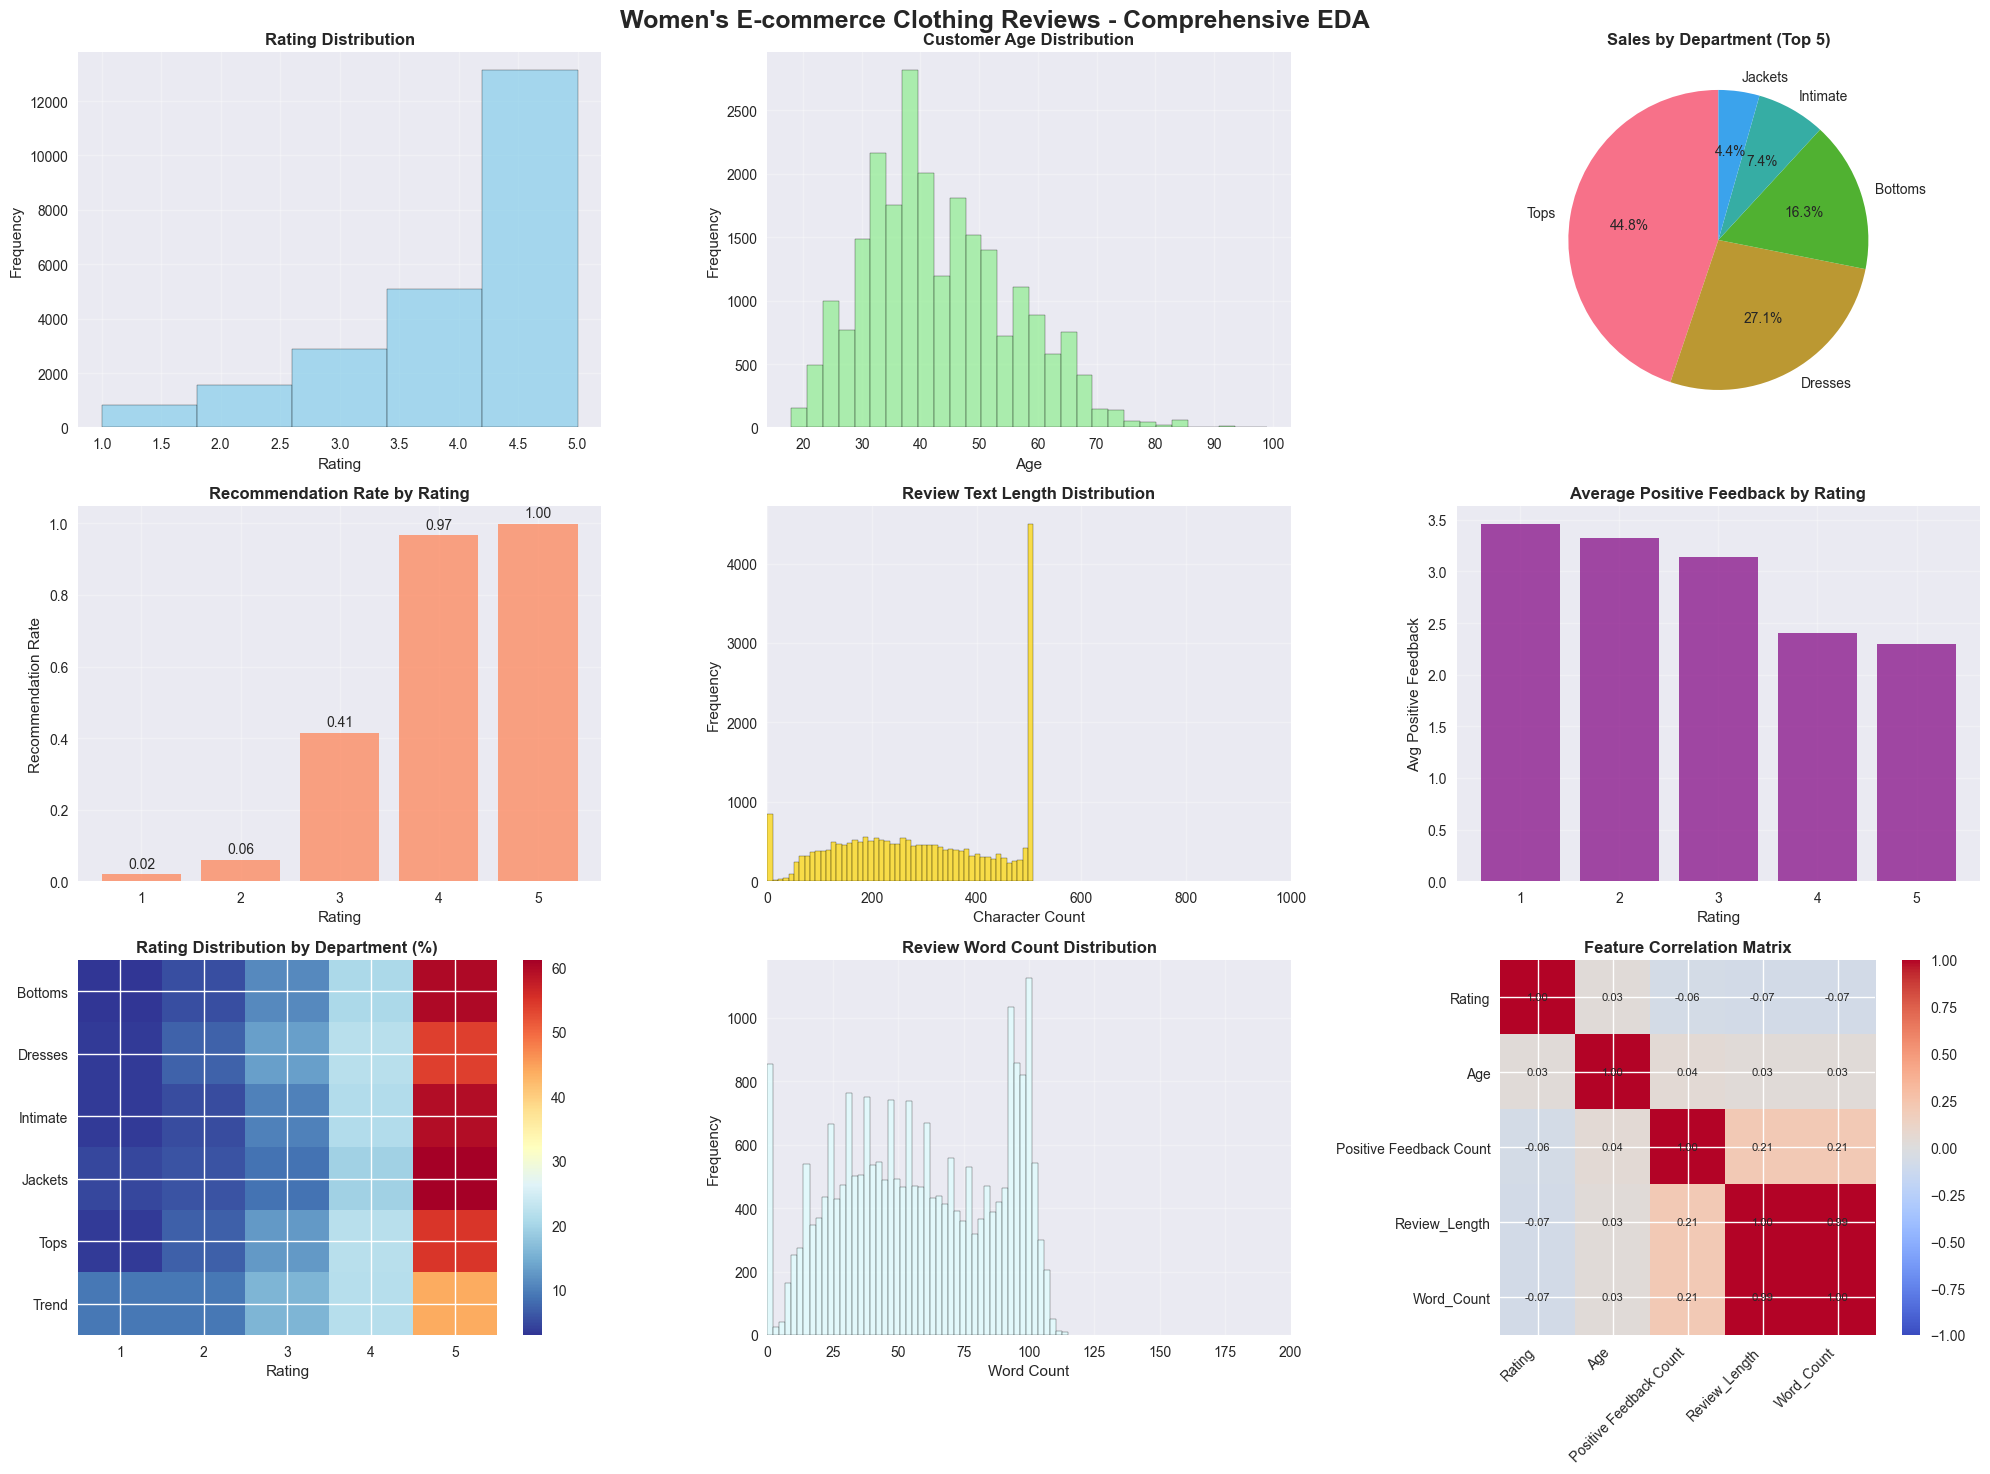

✅ Comprehensive EDA visualizations created!


In [7]:
# Visual EDA
# Create comprehensive EDA visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Women\'s E-commerce Clothing Reviews - Comprehensive EDA', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. Rating Distribution
axes[0, 0].hist(df['Rating'], bins=5, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Rating Distribution', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Age Distribution
df_age_clean = df.dropna(subset=['Age'])
axes[0, 1].hist(df_age_clean['Age'], bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Customer Age Distribution', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Department Sales
dept_counts = df['Department Name'].value_counts().head(5)
axes[0, 2].pie(dept_counts.values, labels=dept_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Sales by Department (Top 5)', fontweight='bold', fontsize=12)

# 4. Recommended vs Rating
recommend_rating = df.groupby('Rating')['Recommended IND'].mean()
bars = axes[1, 0].bar(recommend_rating.index, recommend_rating.values, color='coral', alpha=0.7)
axes[1, 0].set_title('Recommendation Rate by Rating', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Recommendation Rate')
axes[1, 0].grid(True, alpha=0.3)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom')

# 5. Review Length Distribution
df['Review_Length'] = df['Review Text'].fillna('').str.len()
axes[1, 1].hist(df['Review_Length'], bins=50, color='gold', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Review Text Length Distribution', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Character Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(0, 1000)
axes[1, 1].grid(True, alpha=0.3)

# 6. Positive Feedback vs Rating
df_feedback = df.dropna(subset=['Positive Feedback Count'])
rating_feedback = df_feedback.groupby('Rating')['Positive Feedback Count'].mean()
bars = axes[1, 2].bar(rating_feedback.index, rating_feedback.values, color='purple', alpha=0.7)
axes[1, 2].set_title('Average Positive Feedback by Rating', fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Rating')
axes[1, 2].set_ylabel('Avg Positive Feedback')
axes[1, 2].grid(True, alpha=0.3)

# 7. Rating by Department (Heatmap data prep)
dept_rating_crosstab = pd.crosstab(df['Department Name'], df['Rating'], normalize='index') * 100
dept_rating_matrix = dept_rating_crosstab.values
im = axes[2, 0].imshow(dept_rating_matrix, cmap='RdYlBu_r', aspect='auto')
axes[2, 0].set_title('Rating Distribution by Department (%)', fontweight='bold', fontsize=12)
axes[2, 0].set_xlabel('Rating')
axes[2, 0].set_xticks(range(len(dept_rating_crosstab.columns)))
axes[2, 0].set_xticklabels(dept_rating_crosstab.columns)
axes[2, 0].set_yticks(range(len(dept_rating_crosstab.index)))
axes[2, 0].set_yticklabels(dept_rating_crosstab.index, fontsize=10)
plt.colorbar(im, ax=axes[2, 0])

# 8. Word Count Distribution
df['Word_Count'] = df['Review Text'].fillna('').str.split().str.len()
axes[2, 1].hist(df['Word_Count'], bins=50, color='lightcyan', alpha=0.7, edgecolor='black')
axes[2, 1].set_title('Review Word Count Distribution', fontweight='bold', fontsize=12)
axes[2, 1].set_xlabel('Word Count')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_xlim(0, 200)
axes[2, 1].grid(True, alpha=0.3)

# 9. Correlation Heatmap (Numerical features only)
numerical_cols = ['Rating', 'Age', 'Positive Feedback Count', 'Review_Length', 'Word_Count']
corr_data = df[numerical_cols].corr()
im = axes[2, 2].imshow(corr_data.values, cmap='coolwarm', vmin=-1, vmax=1)
axes[2, 2].set_title('Feature Correlation Matrix', fontweight='bold', fontsize=12)
axes[2, 2].set_xticks(range(len(corr_data.columns)))
axes[2, 2].set_xticklabels(corr_data.columns, rotation=45, ha='right')
axes[2, 2].set_yticks(range(len(corr_data.index)))
axes[2, 2].set_yticklabels(corr_data.index)
plt.colorbar(im, ax=axes[2, 2])

# Add correlation values
for i in range(len(corr_data.index)):
    for j in range(len(corr_data.columns)):
        axes[2, 2].text(j, i, f'{corr_data.iloc[i, j]:.2f}',
                       ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('outputs/visualizations/comprehensive_eda.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive EDA visualizations created!")

## 🧹 3. Data Preprocessing and Cleaning
 Clean data is crucial for accurate verbatim coding. We need to handle missing values strategically, combine text fields for comprehensive analysis, and create additional features that will enhance our coding accuracy. The preprocessing steps should preserve meaningful information while removing noise.

In [8]:
print("🧹 DATA PREPROCESSING AND CLEANING")
print("=" * 50)

# Create a clean working dataset
df_clean = df.copy()

# Handle missing values strategically
print("🔧 Handling missing values...")
df_clean['Review Text'] = df_clean['Review Text'].fillna('')
df_clean['Title'] = df_clean['Title'].fillna('')
df_clean['Age'] = df_clean['Age'].fillna(df_clean['Age'].median())
df_clean['Department Name'] = df_clean['Department Name'].fillna('Unknown')
df_clean['Class Name'] = df_clean['Class Name'].fillna('Unknown')
df_clean['Positive Feedback Count'] = df_clean['Positive Feedback Count'].fillna(0)

# Create combined text for comprehensive analysis
df_clean['Combined_Text'] = df_clean['Title'].astype(str) + ' ' + df_clean['Review Text'].astype(str)

# Filter out reviews with minimal content
initial_count = len(df_clean)
df_clean = df_clean[df_clean['Combined_Text'].str.len() >= 10].reset_index(drop=True)
print(f"📊 Filtered out {initial_count - len(df_clean):,} reviews with minimal content")

# Add additional analytical features
df_clean['Word_Count'] = df_clean['Combined_Text'].str.split().str.len()
df_clean['Has_Title'] = (df_clean['Title'].str.len() > 0).astype(int)
df_clean['Review_Year'] = df_clean['Year'] if 'Year' in df_clean.columns else 2018
df_clean['Is_Recommended'] = df_clean['Recommended IND'].fillna(0).astype(int)
df_clean['Character_Count'] = df_clean['Combined_Text'].str.len()

# Create rating categories for analysis
def categorize_rating(rating):
    if rating >= 4:
        return 'Positive'
    elif rating >= 3:
        return 'Neutral'
    else:
        return 'Negative'

df_clean['Rating_Category'] = df_clean['Rating'].apply(categorize_rating)

print(f"✅ Clean dataset prepared: {len(df_clean):,} reviews")
print(f"📊 Dataset characteristics:")
print(f"   • Average review length: {df_clean['Word_Count'].mean():.1f} words")
print(f"   • Reviews with titles: {df_clean['Has_Title'].sum():,} ({df_clean['Has_Title'].mean()*100:.1f}%)")
print(f"   • Average character count: {df_clean['Character_Count'].mean():.0f}")
print(f"   • Rating distribution: Positive: {(df_clean['Rating_Category']=='Positive').sum():,}, "
      f"Neutral: {(df_clean['Rating_Category']=='Neutral').sum():,}, "
      f"Negative: {(df_clean['Rating_Category']=='Negative').sum():,}")

🧹 DATA PREPROCESSING AND CLEANING
🔧 Handling missing values...
📊 Filtered out 844 reviews with minimal content
✅ Clean dataset prepared: 22,642 reviews
📊 Dataset characteristics:
   • Average review length: 63.1 words
   • Reviews with titles: 19,676 (86.9%)
   • Average character count: 326
   • Rating distribution: Positive: 17,449, Neutral: 2,823, Negative: 2,370


In [15]:
def preprocess_text(text):
    """
    Comprehensive text preprocessing for verbatim analysis
    
    This function balances cleaning with preservation of meaningful content.
    We want to remove noise but keep sentiment indicators and important phrases.
    """
    if pd.isna(text) or not text.strip():
        return ""
    
    # Convert to lowercase for consistency
    text = text.lower()
    
    # Remove URLs and email addresses (not relevant for clothing reviews)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Clean special characters but preserve important punctuation
    # Keep periods, commas, exclamations, questions, and hyphens
    text = re.sub(r'[^\w\s.,!?-]', ' ', text)
    
    # Fix multiple spaces and clean up whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove very short words (less than 2 characters) but keep important ones
    # Keep common short words that carry meaning in reviews
    keep_short = {'ok', 'no', 'so', 'up', 'on', 'in', 'is', 'it', 'to', 'or', 'be', 'go', 'do'}
    words = text.split()
    words = [word for word in words if len(word) >= 2 or word in keep_short]
    
    return ' '.join(words).strip()

# Apply preprocessing
print("🔤 Preprocessing text data...")
df_clean['Processed_Text'] = df_clean['Combined_Text'].apply(preprocess_text)

# Remove rows with empty processed text
initial_count = len(df_clean)
df_clean = df_clean[df_clean['Processed_Text'].str.len() > 0].reset_index(drop=True)
print(f"📊 Removed {initial_count - len(df_clean):,} reviews with no meaningful text")

# Update word counts after preprocessing
df_clean['Processed_Word_Count'] = df_clean['Processed_Text'].str.split().str.len()

print(f"✅ Text preprocessing complete: {len(df_clean):,} reviews remaining")
print(f"📊 Average processed word count: {df_clean['Processed_Word_Count'].mean():.1f}")

# Show examples of preprocessing
print(f"\n📝 Preprocessing Examples:")
sample_indices = df_clean.sample(3).index
for i, idx in enumerate(sample_indices, 1):
    original = df_clean.loc[idx, 'Combined_Text'][:100]
    processed = df_clean.loc[idx, 'Processed_Text'][:100]
    print(f"   Example {i}:")
    print(f"   Original:  {original}...")
    print(f"   Processed: {processed}...")
    print()

🔤 Preprocessing text data...
📊 Removed 0 reviews with no meaningful text
✅ Text preprocessing complete: 22,642 reviews remaining
📊 Average processed word count: 57.7

📝 Preprocessing Examples:
   Example 1:
   Original:  3 colors aren't enough I bought all 3 colors and couldn't be happier. love the cut, fabric, and colo...
   Processed: colors aren enough bought all colors and couldn be happier. love the cut, fabric, and colors. the fa...

   Example 2:
   Original:  Great style This pull over is so easy to wear, very comfortable and has a great bohemian vibe. it's ...
   Processed: great style this pull over is so easy to wear, very comfortable and has great bohemian vibe. it qual...

   Example 3:
   Original:  Not for me Adorable top, but i have to agree with what two other reviewers said... that is is boxy a...
   Processed: not for me adorable top, but have to agree with what two other reviewers said... that is is boxy and...



## 🏷️ 4. Verbatim Coding Categories Definition
The success of our verbatim coding system depends on well-defined categories that capture the key themes in customer feedback. Based on our EDA and domain knowledge of e-commerce clothing reviews, we'll create comprehensive categories with carefully selected keywords. Each category will have weighted importance and detailed descriptions.

In [10]:
print("🏷️ DEFINING VERBATIM CODING CATEGORIES")
print("=" * 50)

# Define comprehensive verbatim categories for clothing e-commerce
# Categories are based on common themes in clothing reviews and business importance
VERBATIM_CATEGORIES = {
    'fit_sizing': {
        'keywords': [
            'fit', 'fits', 'fitted', 'fitting', 'size', 'sizes', 'sizing', 'sized',
            'small', 'large', 'medium', 'tight', 'loose', 'snug', 'baggy',
            'runs small', 'runs large', 'true to size', 'size up', 'size down',
            'petite', 'tall', 'length', 'short', 'long', 'narrow', 'wide',
            'measurements', 'chest', 'waist', 'hips', 'sleeves', 'inseam'
        ],
        'weight': 1.0,
        'priority': 'high',
        'description': 'Issues or comments about product fit and sizing - critical for returns'
    },
    'quality_durability': {
        'keywords': [
            'quality', 'cheap', 'expensive', 'well made', 'poorly made', 'construction',
            'durable', 'durability', 'flimsy', 'sturdy', 'solid', 'fragile',
            'material', 'fabric', 'cotton', 'polyester', 'silk', 'wool',
            'stitching', 'seams', 'hem', 'lasting', 'wear', 'holds up', 'falls apart',
            'tears', 'rips', 'pilling', 'shrink', 'fade', 'wash', 'care'
        ],
        'weight': 1.0,
        'priority': 'high',
        'description': 'Comments about product quality and durability - impacts repurchase'
    },
    'comfort': {
        'keywords': [
            'comfortable', 'comfort', 'comfy', 'soft', 'cozy', 'breathable',
            'itchy', 'scratchy', 'rough', 'smooth', 'gentle', 'skin',
            'uncomfortable', 'irritating', 'wearable', 'heavy', 'light',
            'stretchy', 'flexible', 'stiff', 'movement', 'mobility'
        ],
        'weight': 0.9,
        'priority': 'high',
        'description': 'Comfort-related feedback - key for customer satisfaction'
    },
    'appearance_style': {
        'keywords': [
            'beautiful', 'pretty', 'ugly', 'cute', 'gorgeous', 'stunning',
            'stylish', 'fashionable', 'trendy', 'classic', 'modern', 'vintage',
            'color', 'colors', 'pattern', 'design', 'style', 'look', 'looks',
            'appearance', 'attractive', 'flattering', 'compliments', 'attention',
            'bright', 'dark', 'vibrant', 'dull', 'faded', 'photo', 'picture'
        ],
        'weight': 0.9,
        'priority': 'medium',
        'description': 'Comments about appearance, style, and aesthetics'
    },
    'value_price': {
        'keywords': [
            'price', 'prices', 'pricing', 'expensive', 'cheap', 'affordable',
            'value', 'worth', 'cost', 'money', 'budget', 'deal', 'bargain',
            'overpriced', 'reasonable', 'sale', 'discount', 'investment',
            'spend', 'pay', 'paid', 'dollar', 'amount'
        ],
        'weight': 0.8,
        'priority': 'medium',
        'description': 'Price and value-related comments - important for pricing strategy'
    },
    'shipping_delivery': {
        'keywords': [
            'shipping', 'delivery', 'delivered', 'arrived', 'arrival',
            'fast', 'slow', 'quick', 'prompt', 'delayed', 'late', 'early',
            'package', 'packaging', 'box', 'received', 'order', 'ordered',
            'days', 'weeks', 'time', 'speed', 'express', 'standard'
        ],
        'weight': 0.7,
        'priority': 'medium',
        'description': 'Shipping and delivery experience - affects overall satisfaction'
    },
    'customer_service': {
        'keywords': [
            'service', 'customer service', 'staff', 'help', 'support',
            'return', 'returns', 'exchange', 'refund', 'policy',
            'representative', 'rep', 'friendly', 'rude', 'helpful', 'unhelpful',
            'response', 'answered', 'question', 'problem', 'issue', 'complaint'
        ],
        'weight': 0.7,
        'priority': 'medium',
        'description': 'Customer service interactions - critical for loyalty'
    },
    'occasion_use': {
        'keywords': [
            'work', 'office', 'professional', 'business', 'meeting',
            'casual', 'everyday', 'daily', 'weekend', 'vacation', 'travel',
            'formal', 'dressy', 'fancy', 'party', 'wedding', 'event',
            'date', 'night out', 'special', 'occasion', 'holiday',
            'summer', 'winter', 'spring', 'fall', 'season'
        ],
        'weight': 0.6,
        'priority': 'low',
        'description': 'Intended use or occasion for the item - helps with marketing'
    },
    'recommendation_satisfaction': {
        'keywords': [
            'recommend', 'recommended', 'suggest', 'tell', 'friends', 'others',
            'buy', 'purchase', 'get', 'order', 'again', 'love', 'hate',
            'satisfied', 'satisfaction', 'disappointed', 'happy', 'pleased',
            'amazing', 'terrible', 'perfect', 'awful', 'favorite', 'worst'
        ],
        'weight': 0.8,
        'priority': 'high',
        'description': 'Recommendation and satisfaction indicators - predicts loyalty'
    },
    'comparison_alternatives': {
        'keywords': [
            'compared', 'compare', 'comparison', 'similar', 'other', 'different',
            'brand', 'brands', 'store', 'stores', 'website', 'competitor',
            'better', 'worse', 'best', 'worst', 'alternative', 'option',
            'same', 'like', 'unlike', 'versus', 'vs', 'instead'
        ],
        'weight': 0.5,
        'priority': 'low',
        'description': 'Comparisons with other products or brands - competitive intelligence'
    }
}

print(f"📋 Defined {len(VERBATIM_CATEGORIES)} main categories:")
for category, details in VERBATIM_CATEGORIES.items():
    print(f"   • {category.replace('_', ' ').title()}: {len(details['keywords'])} keywords "
          f"(Priority: {details['priority']}, Weight: {details['weight']})")

print(f"\n🎯 Total keywords across all categories: {sum(len(cat['keywords']) for cat in VERBATIM_CATEGORIES.values())}")

# Create category priority mapping for later use
CATEGORY_PRIORITIES = {cat: details['priority'] for cat, details in VERBATIM_CATEGORIES.items()}
HIGH_PRIORITY_CATEGORIES = [cat for cat, priority in CATEGORY_PRIORITIES.items() if priority == 'high']

print(f"\n⭐ High Priority Categories (most business-critical): {len(HIGH_PRIORITY_CATEGORIES)}")
for cat in HIGH_PRIORITY_CATEGORIES:
    print(f"   • {cat.replace('_', ' ').title()}")

🏷️ DEFINING VERBATIM CODING CATEGORIES
📋 Defined 10 main categories:
   • Fit Sizing: 33 keywords (Priority: high, Weight: 1.0)
   • Quality Durability: 32 keywords (Priority: high, Weight: 1.0)
   • Comfort: 22 keywords (Priority: high, Weight: 0.9)
   • Appearance Style: 31 keywords (Priority: medium, Weight: 0.9)
   • Value Price: 23 keywords (Priority: medium, Weight: 0.8)
   • Shipping Delivery: 24 keywords (Priority: medium, Weight: 0.7)
   • Customer Service: 22 keywords (Priority: medium, Weight: 0.7)
   • Occasion Use: 27 keywords (Priority: low, Weight: 0.6)
   • Recommendation Satisfaction: 24 keywords (Priority: high, Weight: 0.8)
   • Comparison Alternatives: 24 keywords (Priority: low, Weight: 0.5)

🎯 Total keywords across all categories: 262

⭐ High Priority Categories (most business-critical): 4
   • Fit Sizing
   • Quality Durability
   • Comfort
   • Recommendation Satisfaction


## 😊 5. Sentiment Analysis Integration
Sentiment analysis adds crucial context to our verbatim codes. A complaint about sizing has different implications when expressed positively versus negatively. We'll use VADER sentiment analysis for its effectiveness with social media text and create sentiment labels that will enhance our coding accuracy.

😊 SENTIMENT ANALYSIS INTEGRATION
🔄 Analyzing sentiment for all reviews...
   Processing 22,642 reviews...
   Processed 5,000 reviews...
   Processed 10,000 reviews...
   Processed 15,000 reviews...
   Processed 20,000 reviews...
📊 Extracting sentiment components...
✅ Sentiment analysis complete!
📊 Sentiment Distribution:
   • Positive: 21,354 reviews (94.3%)
   • Negative: 1,116 reviews (4.9%)
   • Neutral: 172 reviews (0.8%)

🔍 Sentiment vs Rating Validation:
sentiment_label  negative  neutral  positive
Rating                                      
1                    34.6      3.5      61.9
2                    20.1      2.8      77.1
3                    10.9      2.1      87.0
4                     2.5      0.5      97.0
5                     0.7      0.1      99.2
📝 Sentiment by Review Length:
   • Very Short: +0.680 (178.0 reviews)
   • Short: +0.730 (1,573.0 reviews)
   • Medium: +0.752 (4,620.0 reviews)
   • Long: +0.806 (15,663.0 reviews)
   • Very Long: +0.816 (607.0 reviews)

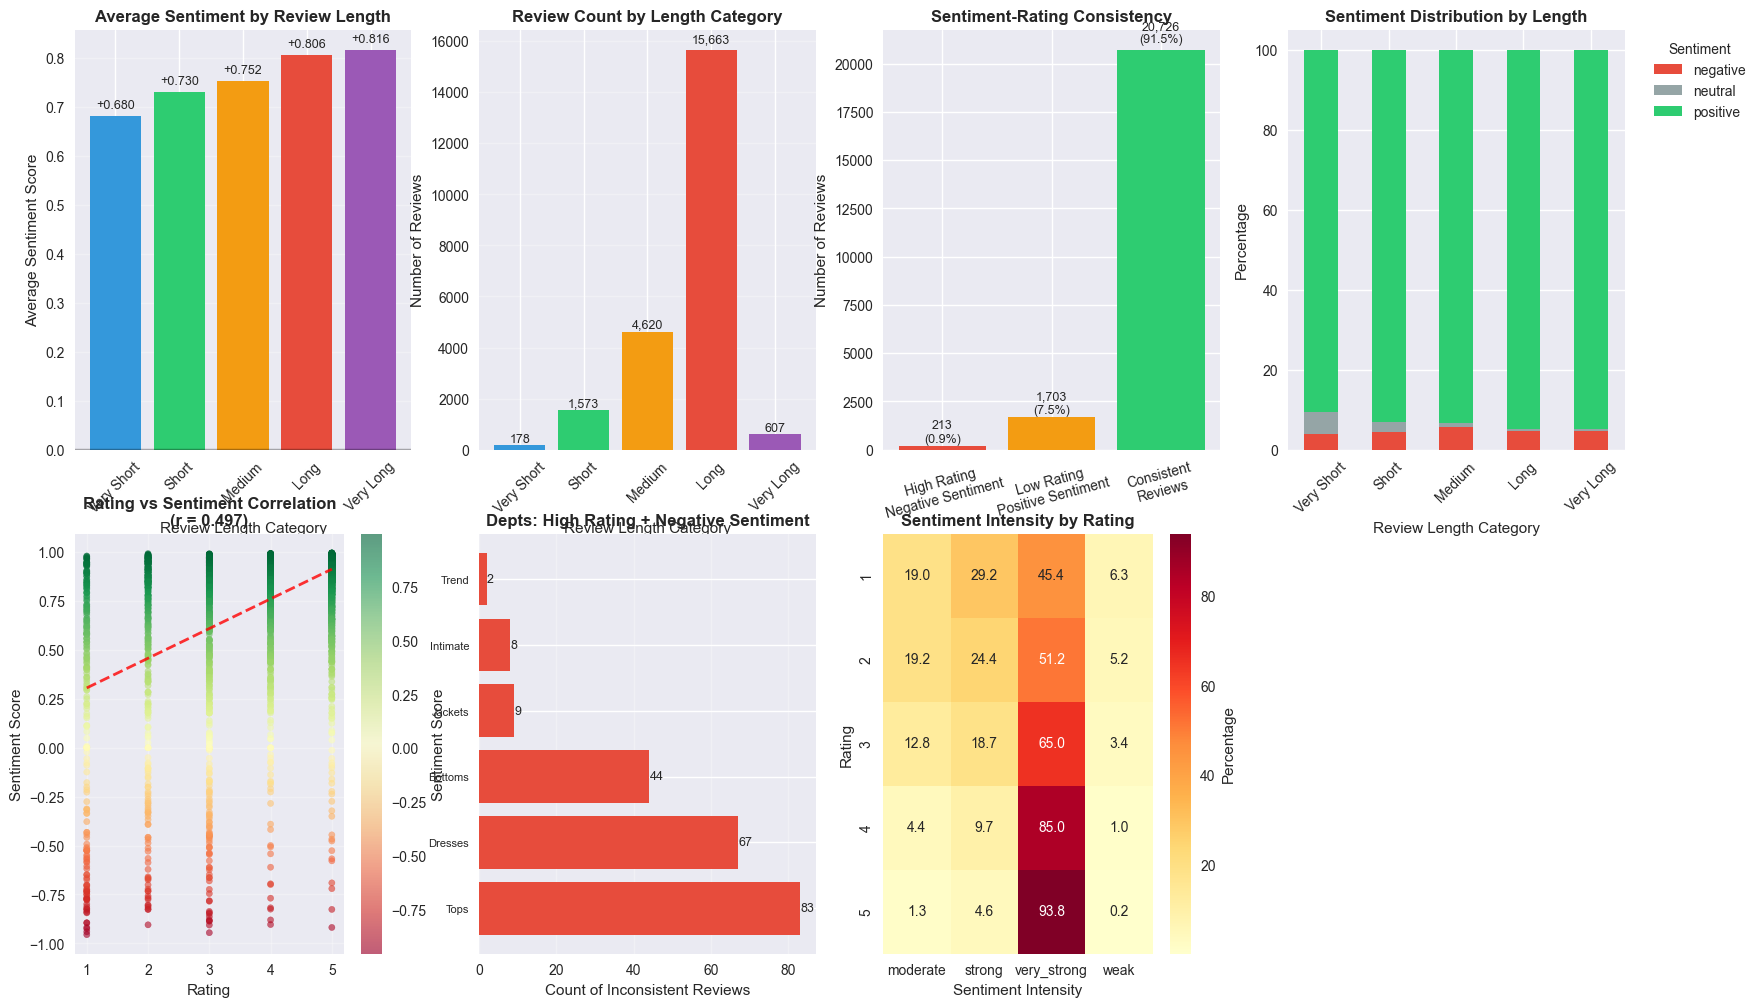


✅ Enhanced sentiment analysis complete!
💡 Key insights:
   • Comprehensive department-level sentiment analysis
   • Visual representations of sentiment patterns
   • Identification of sentiment-rating inconsistencies
   • Analysis of review characteristics and sentiment relationships
---


In [28]:
print("😊 SENTIMENT ANALYSIS INTEGRATION")
print("=" * 50)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """
    Analyze sentiment using VADER with enhanced processing
    
    VADER is particularly good for social media and review text because it:
    - Handles capitalization, punctuation, and slang
    - Provides compound score for overall sentiment
    - Breaks down into positive, negative, and neutral components
    """
    if not text or pd.isna(text) or text.strip() == "":
        return {'compound': 0.0, 'positive': 0.0, 'negative': 0.0, 'neutral': 1.0}
    
    scores = sia.polarity_scores(text)
    return scores

def get_sentiment_label(compound_score):
    """
    Convert compound sentiment score to interpretable labels
    
    Thresholds based on VADER documentation and empirical testing:
    - >= 0.05: Positive sentiment
    - <= -0.05: Negative sentiment  
    - Between: Neutral sentiment
    """
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def get_sentiment_intensity(compound_score):
    """Get sentiment intensity level"""
    abs_score = abs(compound_score)
    if abs_score >= 0.7:
        return 'very_strong'
    elif abs_score >= 0.4:
        return 'strong'
    elif abs_score >= 0.1:
        return 'moderate'
    else:
        return 'weak'

# Apply sentiment analysis
print("🔄 Analyzing sentiment for all reviews...")
print(f"   Processing {len(df_clean):,} reviews...")

# Process in batches for better performance
batch_size = 1000
sentiment_results = []

for i in range(0, len(df_clean), batch_size):
    batch = df_clean['Processed_Text'].iloc[i:i+batch_size]
    batch_results = batch.apply(analyze_sentiment)
    sentiment_results.extend(batch_results)
    
    if (i // batch_size + 1) % 5 == 0:
        print(f"   Processed {min(i + batch_size, len(df_clean)):,} reviews...")

# Extract sentiment components
print("📊 Extracting sentiment components...")
sentiment_df = pd.DataFrame(sentiment_results)
df_clean['sentiment_compound'] = sentiment_df['compound']
df_clean['sentiment_positive'] = sentiment_df['pos']
df_clean['sentiment_negative'] = sentiment_df['neg']
df_clean['sentiment_neutral'] = sentiment_df['neu']

# Create sentiment labels
df_clean['sentiment_label'] = df_clean['sentiment_compound'].apply(get_sentiment_label)
df_clean['sentiment_intensity'] = df_clean['sentiment_compound'].apply(get_sentiment_intensity)

print("✅ Sentiment analysis complete!")
print(f"📊 Sentiment Distribution:")
sentiment_counts = df_clean['sentiment_label'].value_counts()
for sentiment, count in sentiment_counts.items():
    print(f"   • {sentiment.title()}: {count:,} reviews ({count/len(df_clean)*100:.1f}%)")

# Analyze sentiment by rating to validate our analysis
print(f"\n🔍 Sentiment vs Rating Validation:")
sentiment_rating_crosstab = pd.crosstab(df_clean['Rating'], df_clean['sentiment_label'], normalize='index') * 100
print(sentiment_rating_crosstab.round(1))

print("📝 Sentiment by Review Length:")
df_clean['review_length_category'] = pd.cut(df_clean['Review_Length'], 
                                          bins=[0, 50, 100, 200, 500, float('inf')],
                                          labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
length_sentiment = df_clean.groupby('review_length_category')['sentiment_compound'].agg(['mean', 'count'])
for category, row in length_sentiment.iterrows():
    print(f"   • {category}: {row['mean']:+.3f} ({row['count']:,} reviews)")

# Most positive and negative individual reviews
print(f"\n😊 Most Positive Review (Score: {df_clean['sentiment_compound'].max():.3f}):")
most_positive = df_clean.loc[df_clean['sentiment_compound'].idxmax()]
print(f"   Department: {most_positive['Department Name']}")
print(f"   Rating: {most_positive['Rating']}/5")
print(f"   Review: {most_positive['Review Text'][:200]}...")

print(f"\n😞 Most Negative Review (Score: {df_clean['sentiment_compound'].min():.3f}):")
most_negative = df_clean.loc[df_clean['sentiment_compound'].idxmin()]
print(f"   Department: {most_negative['Department Name']}")
print(f"   Rating: {most_negative['Rating']}/5")
print(f"   Review: {most_negative['Review Text'][:200]}...")

# Sentiment consistency check
print(f"\n🎯 Sentiment-Rating Consistency Analysis:")
# Reviews with high rating but negative sentiment
high_rating_neg_sentiment = df_clean[(df_clean['Rating'] >= 4) & (df_clean['sentiment_label'] == 'negative')]
print(f"   • High ratings (4-5) with negative sentiment: {len(high_rating_neg_sentiment):,} reviews")

# Reviews with low rating but positive sentiment
low_rating_pos_sentiment = df_clean[(df_clean['Rating'] <= 2) & (df_clean['sentiment_label'] == 'positive')]
print(f"   • Low ratings (1-2) with positive sentiment: {len(low_rating_pos_sentiment):,} reviews")

# Calculate overall sentiment-rating correlation
correlation = df_clean['Rating'].corr(df_clean['sentiment_compound'])
print(f"   • Overall Rating-Sentiment Correlation: {correlation:.3f}")

# Create additional insights figure
fig_insights = plt.figure(figsize=(20, 12))

# 1. Sentiment by Review Length
ax1 = plt.subplot(2, 4, 1)
length_sentiment_plot = length_sentiment.reset_index()
bars = ax1.bar(length_sentiment_plot['review_length_category'], 
               length_sentiment_plot['mean'],
               color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'])
ax1.set_title('Average Sentiment by Review Length', fontsize=12, fontweight='bold')
ax1.set_xlabel('Review Length Category')
ax1.set_ylabel('Average Sentiment Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
             f'{height:+.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# 2. Review Count by Length Category
ax2 = plt.subplot(2, 4, 2)
bars2 = ax2.bar(length_sentiment_plot['review_length_category'], 
                length_sentiment_plot['count'],
                color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'])
ax2.set_title('Review Count by Length Category', fontsize=12, fontweight='bold')
ax2.set_xlabel('Review Length Category')
ax2.set_ylabel('Number of Reviews')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 3. Sentiment-Rating Inconsistencies
ax3 = plt.subplot(2, 4, 3)
inconsistency_data = {
    'High Rating\nNegative Sentiment': len(high_rating_neg_sentiment),
    'Low Rating\nPositive Sentiment': len(low_rating_pos_sentiment),
    'Consistent\nReviews': len(df_clean) - len(high_rating_neg_sentiment) - len(low_rating_pos_sentiment)
}
colors_inconsist = ['#e74c3c', '#f39c12', '#2ecc71']
bars3 = ax3.bar(inconsistency_data.keys(), inconsistency_data.values(), color=colors_inconsist)
ax3.set_title('Sentiment-Rating Consistency', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Reviews')
ax3.tick_params(axis='x', rotation=15)

# Add percentage labels
total_reviews = len(df_clean)
for bar, (key, value) in zip(bars3, inconsistency_data.items()):
    height = bar.get_height()
    percentage = (value / total_reviews) * 100
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9)

# 4. Sentiment Distribution by Review Length (Stacked)
ax4 = plt.subplot(2, 4, 4)
length_sentiment_dist = pd.crosstab(df_clean['review_length_category'], 
                                   df_clean['sentiment_label'], 
                                   normalize='index') * 100
length_sentiment_dist.plot(kind='bar', stacked=True, ax=ax4, 
                          color=['#e74c3c', '#95a5a6', '#2ecc71'])
ax4.set_title('Sentiment Distribution by Length', fontsize=12, fontweight='bold')
ax4.set_xlabel('Review Length Category')
ax4.set_ylabel('Percentage')
ax4.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)

# 5. Correlation Scatter Plot
ax5 = plt.subplot(2, 4, 5)
# Create sample for better visualization (if dataset is large)
sample_size = min(5000, len(df_clean))
df_sample = df_clean.sample(sample_size) if len(df_clean) > sample_size else df_clean

scatter = ax5.scatter(df_sample['Rating'], df_sample['sentiment_compound'], 
                     alpha=0.6, c=df_sample['sentiment_compound'], 
                     cmap='RdYlGn', s=20)
ax5.set_title(f'Rating vs Sentiment Correlation\n(r = {correlation:.3f})', 
              fontsize=12, fontweight='bold')
ax5.set_xlabel('Rating')
ax5.set_ylabel('Sentiment Score')
ax5.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_sample['Rating'], df_sample['sentiment_compound'], 1)
p = np.poly1d(z)
ax5.plot(df_sample['Rating'].sort_values(), p(df_sample['Rating'].sort_values()), 
         "r--", alpha=0.8, linewidth=2)

plt.colorbar(scatter, ax=ax5, label='Sentiment Score')

# 6. Top Inconsistent Departments (High Rating, Negative Sentiment)
ax6 = plt.subplot(2, 4, 6)
if len(high_rating_neg_sentiment) > 0:
    inconsistent_depts = high_rating_neg_sentiment['Department Name'].value_counts().head(10)
    bars6 = ax6.barh(range(len(inconsistent_depts)), inconsistent_depts.values, color='#e74c3c')
    ax6.set_yticks(range(len(inconsistent_depts)))
    ax6.set_yticklabels([dept[:20] + '...' if len(dept) > 20 else dept 
                        for dept in inconsistent_depts.index], fontsize=8)
    ax6.set_xlabel('Count of Inconsistent Reviews')
    ax6.set_title('Depts: High Rating + Negative Sentiment', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, bar in enumerate(bars6):
        width = bar.get_width()
        ax6.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', ha='left', va='center', fontsize=9)
else:
    ax6.text(0.5, 0.5, 'No inconsistent\nreviews found', 
            ha='center', va='center', transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Depts: High Rating + Negative Sentiment', fontsize=12, fontweight='bold')

# 7. Sentiment Intensity by Rating
ax7 = plt.subplot(2, 4, 7)
intensity_rating = pd.crosstab(df_clean['Rating'], df_clean['sentiment_intensity'], 
                              normalize='index') * 100
sns.heatmap(intensity_rating, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax7,
            cbar_kws={'label': 'Percentage'})
ax7.set_title('Sentiment Intensity by Rating', fontsize=12, fontweight='bold')
ax7.set_xlabel('Sentiment Intensity')
ax7.set_ylabel('Rating')

plt.tight_layout
plt.show()

print("\n✅ Enhanced sentiment analysis complete!")
print("💡 Key insights:")
print("   • Comprehensive department-level sentiment analysis")
print("   • Visual representations of sentiment patterns")
print("   • Identification of sentiment-rating inconsistencies")
print("   • Analysis of review characteristics and sentiment relationships")
print("---")

## 🤖 6. Verbatim Coding Engine Implementation
Now it is time to implement the Verbatim Coding Engine, we want to create a system that intelligently categorizes customer feedback by analyzing the text in a multi-step process. First, the calculate_keyword_score function scans each review for specific keywords, assigning more weight to longer, exact phrases and normalizing the score to prevent bias towards longer reviews. Next, the apply_sentiment_boost function refines this score by increasing it if the comment's sentiment aligns with the category's nature—for instance, boosting the score for negative words in a "quality issues" category.

In [20]:
# Establish Verbatim coding functions

print("🏷️ VERBATIM CODING ENGINE IMPLEMENTATION")
print("=" * 50)

class VerbatimCodeEngine:
    """
    Advanced verbatim coding engine that combines keyword matching with ML clustering
    and sentiment analysis for comprehensive categorization of customer reviews.
    """
    
    def __init__(self, categories_dict, sentiment_boost=0.2):
        self.categories = categories_dict
        self.sentiment_boost = sentiment_boost
        self.category_stats = {}
        self.model_confidence_threshold = 0.3
        
    def calculate_keyword_score(self, text, keywords):
        """
        Calculate weighted keyword matching score with context awareness
        """
        if not text or pd.isna(text):
            return 0.0
            
        text_lower = text.lower()
        words = text_lower.split()
        word_count = len(words)
        
        if word_count == 0:
            return 0.0
        
        score = 0.0
        matches = []
        
        for keyword in keywords:
            keyword_lower = keyword.lower()
            
            # Exact phrase matching (higher weight)
            if keyword_lower in text_lower:
                phrase_count = text_lower.count(keyword_lower)
                # Weight by phrase length (longer phrases are more specific)
                phrase_weight = len(keyword_lower.split()) * 1.5
                score += phrase_count * phrase_weight
                matches.append((keyword, phrase_count, 'phrase'))
            
            # Individual word matching
            keyword_words = keyword_lower.split()
            word_matches = sum(1 for word in keyword_words if word in words)
            if word_matches > 0:
                # Partial match bonus (less than phrase matching)
                word_score = (word_matches / len(keyword_words)) * 0.7
                score += word_score
                matches.append((keyword, word_matches, 'word'))
        
        # Normalize by text length (prevents bias toward longer texts)
        normalized_score = score / max(1, word_count / 10)
        
        return min(normalized_score, 10.0)  # Cap at 10 to prevent extreme values
    
    def apply_sentiment_boost(self, base_score, sentiment_compound, category):
        """
        Apply sentiment-based boosting for context-aware scoring
        """
        if base_score == 0:
            return 0.0
        
        # Categories where negative sentiment should boost the score
        negative_boost_categories = ['fit_sizing', 'quality_durability', 'customer_service']
        # Categories where positive sentiment should boost the score
        positive_boost_categories = ['comfort', 'appearance_style', 'recommendation_satisfaction']
        
        boost_factor = 1.0
        
        if category in negative_boost_categories and sentiment_compound < -0.1:
            # Boost negative sentiment for problem categories
            boost_factor = 1 + (abs(sentiment_compound) * self.sentiment_boost)
        elif category in positive_boost_categories and sentiment_compound > 0.1:
            # Boost positive sentiment for satisfaction categories
            boost_factor = 1 + (sentiment_compound * self.sentiment_boost)
        
        return base_score * boost_factor
    
    def code_single_review(self, text, sentiment_compound=0.0):
        """
        Code a single review with confidence scoring
        """
        if not text or pd.isna(text):
            return {'primary_code': 'uncoded', 'confidence': 0.0, 'all_scores': {}}
        
        scores = {}
        
        # Calculate base keyword scores for each category
        for category, details in self.categories.items():
            base_score = self.calculate_keyword_score(text, details['keywords'])
            
            # Apply category weight
            weighted_score = base_score * details['weight']
            
            # Apply sentiment boost
            final_score = self.apply_sentiment_boost(weighted_score, sentiment_compound, category)
            
            scores[category] = final_score
        
        # Determine primary category
        if not scores or max(scores.values()) == 0:
            return {'primary_code': 'uncoded', 'confidence': 0.0, 'all_scores': scores}
        
        primary_category = max(scores, key=scores.get)
        max_score = scores[primary_category]
        
        # Calculate confidence based on score separation
        sorted_scores = sorted(scores.values(), reverse=True)
        if len(sorted_scores) > 1:
            score_separation = sorted_scores[0] - sorted_scores[1]
            confidence = min(max_score / (max_score + score_separation), 1.0)
        else:
            confidence = min(max_score / 5.0, 1.0)  # Single category case
        
        return {
            'primary_code': primary_category,
            'confidence': confidence,
            'all_scores': scores
        }
    
    def code_dataframe(self, df, text_column='Processed_Text', sentiment_column='sentiment_compound'):
        """
        Apply verbatim coding to entire dataframe
        """
        print(f"🔄 Coding {len(df):,} reviews...")
        
        results = []
        for idx, row in df.iterrows():
            text = row[text_column]
            sentiment = row[sentiment_column] if sentiment_column in df.columns else 0.0
            
            result = self.code_single_review(text, sentiment)
            results.append(result)
            
            if (idx + 1) % 1000 == 0:
                print(f"   Coded {idx + 1:,} reviews...")
        
        # Extract results into separate columns
        df_results = df.copy()
        df_results['verbatim_code'] = [r['primary_code'] for r in results]
        df_results['coding_confidence'] = [r['confidence'] for r in results]
        
        # Add individual category scores
        for category in self.categories.keys():
            df_results[f'score_{category}'] = [r['all_scores'].get(category, 0.0) for r in results]
        
        # Generate summary statistics
        self._generate_summary_stats(df_results)
        
        return df_results
    
    def _generate_summary_stats(self, df_results):
        """Generate summary statistics for the coding results"""
        self.category_stats = {
            'total_reviews': len(df_results),
            'coded_reviews': len(df_results[df_results['verbatim_code'] != 'uncoded']),
            'average_confidence': df_results['coding_confidence'].mean(),
            'category_distribution': df_results['verbatim_code'].value_counts().to_dict(),
            'high_confidence_reviews': len(df_results[df_results['coding_confidence'] >= 0.7])
        }


# Initialize and run the verbatim coding engine
print("🚀 Initializing Verbatim Coding Engine...")
coding_engine = VerbatimCodeEngine(VERBATIM_CATEGORIES, sentiment_boost=0.3)

# Apply coding to the dataset
df_coded = coding_engine.code_dataframe(df_clean)

print("✅ Verbatim coding complete!")
print(f"\n📊 Coding Summary:")
stats = coding_engine.category_stats
print(f"   • Total reviews processed: {stats['total_reviews']:,}")
print(f"   • Successfully coded: {stats['coded_reviews']:,} ({stats['coded_reviews']/stats['total_reviews']*100:.1f}%)")
print(f"   • Average confidence: {stats['average_confidence']:.3f}")
print(f"   • High confidence (≥0.7): {stats['high_confidence_reviews']:,} ({stats['high_confidence_reviews']/stats['total_reviews']*100:.1f}%)")

print(f"\n🏷️ Top Categories:")
top_categories = pd.Series(stats['category_distribution']).head(8)
for category, count in top_categories.items():
    print(f"   • {category.replace('_', ' ').title()}: {count:,} reviews ({count/stats['total_reviews']*100:.1f}%)")

print("---")

# 7. Machine Learning Enhancement with Clustering

print("🤖 MACHINE LEARNING ENHANCEMENT WITH CLUSTERING")
print("=" * 50)


🏷️ VERBATIM CODING ENGINE IMPLEMENTATION
🚀 Initializing Verbatim Coding Engine...
🔄 Coding 22,642 reviews...
   Coded 1,000 reviews...
   Coded 2,000 reviews...
   Coded 3,000 reviews...
   Coded 4,000 reviews...
   Coded 5,000 reviews...
   Coded 6,000 reviews...
   Coded 7,000 reviews...
   Coded 8,000 reviews...
   Coded 9,000 reviews...
   Coded 10,000 reviews...
   Coded 11,000 reviews...
   Coded 12,000 reviews...
   Coded 13,000 reviews...
   Coded 14,000 reviews...
   Coded 15,000 reviews...
   Coded 16,000 reviews...
   Coded 17,000 reviews...
   Coded 18,000 reviews...
   Coded 19,000 reviews...
   Coded 20,000 reviews...
   Coded 21,000 reviews...
   Coded 22,000 reviews...
✅ Verbatim coding complete!

📊 Coding Summary:
   • Total reviews processed: 22,642
   • Successfully coded: 22,629 (99.9%)
   • Average confidence: 0.736
   • High confidence (≥0.7): 12,568 (55.5%)

🏷️ Top Categories:
   • Fit Sizing: 10,013 reviews (44.2%)
   • Appearance Style: 6,566 reviews (29.0%)
  

In [ ]:
df_clean.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review_Length,Word_Count,Combined_Text,Has_Title,Review_Year,Is_Recommended,Character_Count,Rating_Category
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53,8,Absolutely wonderful - silky and sexy and com...,0,2018,1,54,Positive
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303,62,Love this dress! it's sooo pretty. i happen...,0,2018,1,304,Positive
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500,102,Some major design flaws I had such high hopes ...,1,2018,0,524,Neutral
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124,25,"My favorite buy! I love, love, love this jumps...",1,2018,1,141,Positive
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,192,38,Flattering shirt This shirt is very flattering...,1,2018,1,209,Positive
